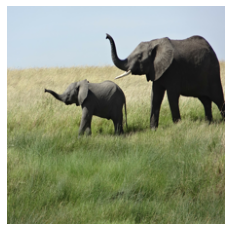

In [1]:
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import requests
from io import BytesIO
import numpy as np
from matplotlib import pyplot as plt

#Get an image for the example

url = 'https://keras.io/img/examples/vision/grad_cam/grad_cam_4_0.jpg'
response = requests.get(url)
image = Image.open(BytesIO(response.content)).convert('RGB')
image = np.array(image.resize((224,224)))

def show(im):
    plt.figure(facecolor='white')
    plt.imshow(im)
    plt.axis('off')

show(image)

In [2]:
#Create a model

base_model = keras.applications.VGG16(weights='imagenet', include_top = False)

input_shape = (224, 224, 3)
inputs = keras.Input(shape=input_shape)

x = tf.keras.applications.vgg16.preprocess_input(inputs)
x = base_model(x,training = False)

x = keras.layers.Dropout(0.5)(x)
x = keras.layers.GlobalAveragePooling2D()(x)

out= keras.layers.Dense(2, activation = 'softmax')(x)
model = keras.Model(inputs, out)

model.summary()


58892288/58889256 [==============================] - 0s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_______________________________________________________

In [3]:
#Meaningless prediction since the model hasn't been fine tuned yet, but it's just for the example.
prepared_image = np.expand_dims(image,0)
print('meaningless example prediction -', model.predict(prepared_image))

meaningless example prediction - [[4.6944765e-06 9.9999535e-01]]


In [4]:
#Make GradCAM heatmap following the Keras tutorial.

last_conv_layer = model.layers[-4].layers[-1] #Last convolution of the vgg16 model/'layer'
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

# Second, we create a model that maps the activations of the last conv
# layer to the final class predictions
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

# Then, we compute the gradient of the top predicted class for our input image
# with respect to the activations of the last conv layer
with tf.GradientTape() as tape:
    # Compute activations of the last conv layer and make the tape watch it
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    # Compute class predictions
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

# This is the gradient of the top predicted class with regard to
# the output feature map of the last conv layer
grads = tape.gradient(top_class_channel, last_conv_layer_output)

# This is a vector where each entry is the mean intensity of the gradient
# over a specific feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the top predicted class
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(last_conv_layer_output, axis=-1)

# For visualization purpose, we will also normalize the heatmap between 0 & 1
heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_1:0", shape=(None, None, None, 3), dtype=float32) at layer "block1_conv1". The following previous layers were accessed without issue: []

In [5]:
#Trying to 'flatten' the model to see if helps

layers_flat=[]
for layer in model.layers:
    try:
        layers_flat.extend(layer.layers)
    except AttributeError:
        layers_flat.append(layer)
inputs = layers_flat[0].output
x = layers_flat[1](inputs)
for layer in layers_flat[1:]:
    x = layer(x)
    
new_model = keras.Model(inputs,x)
new_model.summary()

Model: "functional_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens multiple             0           input_2[0][0]                    
                                                                 tf_op_layer_strided_slice[1][0]  
__________________________________________________________________________________________________
tf_op_layer_BiasAdd (TensorFlow multiple             0           tf_op_layer_strided_slice[2][0]  
__________________________________________________________________________________________________
input_1 (InputLayer)            multiple             0           tf_op_layer_BiasAdd[1]

In [6]:
#Make GradCAM heatmap following the Keras tutorial.

last_conv_layer = new_model.layers[-4] #Last convolution of the vgg16 model/'layer'
last_conv_layer_model = keras.Model(new_model.inputs, last_conv_layer.output)

# Second, we create a model that maps the activations of the last conv
# layer to the final class predictions
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

# Then, we compute the gradient of the top predicted class for our input image
# with respect to the activations of the last conv layer
with tf.GradientTape() as tape:
    # Compute activations of the last conv layer and make the tape watch it
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    # Compute class predictions
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

# This is the gradient of the top predicted class with regard to
# the output feature map of the last conv layer
grads = tape.gradient(top_class_channel, last_conv_layer_output)

# This is a vector where each entry is the mean intensity of the gradient
# over a specific feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the top predicted class
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(last_conv_layer_output, axis=-1)

# For visualization purpose, we will also normalize the heatmap between 0 & 1
heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_1:0", shape=(None, None, None, 3), dtype=float32) at layer "block1_conv1". The following previous layers were accessed without issue: []